In [37]:
#from google.colab import drive
#drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import urllib.request
import cv2
from sklearn.metrics import confusion_matrix
from plot_model import plot_model
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from PIL import Image
from matplotlib.patches import Rectangle
from numpy import asarray
from mtcnn import MTCNN
import random
import time
import pickle
# Tensorflow Library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model, to_categorical
from keras.metrics import Accuracy, CategoricalAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

### Face Detection

In [38]:
def store_image(url, local_file_name):
  with urllib.request.urlopen(url) as resource:
    with open(local_file_name, 'wb') as f:
      f.write(resource.read())

def highlight_faces(image_path, faces):
  # display image
  image = plt.imread(image_path)
  plt.imshow(image)

  ax = plt.gca()

  # for each face, draw a rectangle based on coordinates

  for face in faces:
    x, y, width, height = face['box']
    box_crop = (x, y, width, height)

    face_border = Rectangle((x, y), width, height, fill=False, color='red')
    ax.add_patch(face_border)
  plt.show()

def extract_face_from_image(image_path, required_size=(48, 48)):
  # load image and detect faces
  image = plt.imread(image_path)
  detector = MTCNN()
  faces = detector.detect_faces(image)

  face_images = []

  for face in faces:
    # extract the bounding box from the requested face
    x1, y1, width, height = face['box']
    x2, y2 = x1 + width, y1 + height

    # extract the face
    face_boundary = image[y1:y2, x1:x2]

    grayscale_img = np.mean(face_boundary, axis=2)
    # resize pixels to the model size
    face_image = Image.fromarray(grayscale_img)
    face_image = face_image.resize(required_size)
    face_array = asarray(face_image)
    face_images.append(face_array.tolist())

  return face_images

5/5 [==============================] - 0s 2ms/step
[{'box': [316, 473, 74, 103], 'confidence': 1.0, 'keypoints': {'left_eye': (344, 510), 'right_eye': (376, 512), 'nose': (365, 527), 'mouth_left': (342, 545), 'mouth_right': (374, 546)}}, {'box': [760, 240, 69, 97], 'confidence': 0.9999943971633911, 'keypoints': {'left_eye': (782, 278), 'right_eye': (812, 279), 'nose': (800, 296), 'mouth_left': (784, 314), 'mouth_right': (811, 315)}}, {'box': [203, 202, 71, 92], 'confidence': 0.9999924898147583, 'keypoints': {'left_eye': (230, 238), 'right_eye': (260, 236), 'nose': (249, 253), 'mouth_left': (234, 273), 'mouth_right': (260, 271)}}, {'box': [614, 436, 73, 97], 'confidence': 0.9999817609786987, 'keypoints': {'left_eye': (639, 470), 'right_eye': (671, 469), 'nose': (658, 490), 'mouth_left': (643, 509), 'mouth_right': (669, 508)}}, {'box': [1362, 217, 71, 90], 'confidence': 0.9997562766075134, 'keypoints': {'left_eye': (1384, 252), 'right_eye': (1414, 251), 'nose': (1401, 269), 'mouth_left':

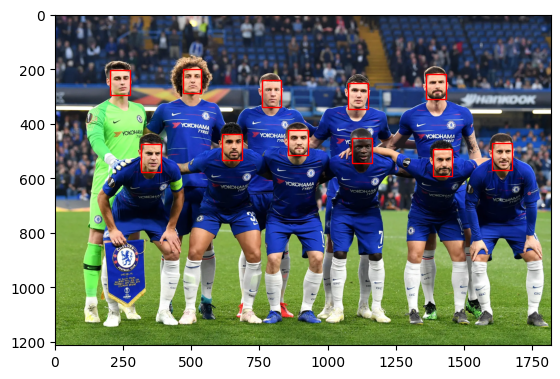

In [39]:
image = plt.imread('chelsea.jpg')
detector = MTCNN()
faces_staring_xi = detector.detect_faces(image)
print(faces_staring_xi)
highlight_faces('chelsea.jpg', faces_staring_xi)

## Emotion Recognition

#### Data Preperation & Preprocessing

In [40]:
data_directory = "C:/Users/ADMIN/Downloads/multi_face_emo_reg"
train_directory = os.path.join(data_directory, "train")
test_directory = os.path.join(data_directory, "test")

print(f"Data directory     {data_directory}")
print(f"Train directory    {train_directory}")
print(f"Test directory     {test_directory}")

Data directory     C:/Users/ADMIN/Downloads/multi_face_emo_reg
Train directory    C:/Users/ADMIN/Downloads/multi_face_emo_reg\train
Test directory     C:/Users/ADMIN/Downloads/multi_face_emo_reg\test


In [41]:
expressions_list = os.listdir(train_directory)
expressions_list

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [42]:
train_dataset_info_df = pd.DataFrame(columns=["Expression", "Size", "Proportion %"])
train_expression_size = []

for expression in expressions_list:
    
    index = expressions_list.index(expression)
    
    train_expression_directory = os.path.join(train_directory, expression)
    train_expression_size.append(len(os.listdir(train_expression_directory)))
    
train_expression_proportion = [round((expression_size / sum(train_expression_size)) * 100, 2)\
                               for expression_size in train_expression_size]

train_dataset_info_df["Expression"] = expressions_list
train_dataset_info_df["Size"] = train_expression_size
train_dataset_info_df["Proportion %"] = train_expression_proportion

total_size = train_dataset_info_df["Size"].sum()
total_proportion = train_dataset_info_df["Proportion %"].sum()

total_row = pd.DataFrame({"Expression": ["Total"],
                          "Size": [total_size],
                          "Proportion %": [total_proportion]})

train_dataset_info_df = pd.concat([train_dataset_info_df, total_row], ignore_index=True)

train_dataset_info_df = train_dataset_info_df.style
train_dataset_info_df = train_dataset_info_df.apply(lambda x: ['background-color: green' if\
                                                    i == len(x)-1 else ''\
                                                    for i in range(len(x))], axis=0)

train_dataset_info_df

,Expression,Size,Proportion %
0,angry,3995,13.120000
1,disgust,2180,7.160000
2,fear,4097,13.450000
3,happy,7215,23.690000
4,neutral,4965,16.300000
5,sad,4830,15.860000
6,surprise,3171,10.410000
7,Total,30453,99.990000


In [43]:
test_dataset_info_df = pd.DataFrame(columns=["Expression", "Size", "Proportion %"])
test_expression_size = []

for expression in expressions_list:
    
    index = expressions_list.index(expression)
    
    test_expression_directory = os.path.join(test_directory, expression)
    test_expression_size.append(len(os.listdir(test_expression_directory)))
    
test_expression_proportion = [round((expression_size / sum(test_expression_size)) * 100, 2)\
                              for expression_size in test_expression_size]

test_dataset_info_df["Expression"] = expressions_list
test_dataset_info_df["Size"] = test_expression_size
test_dataset_info_df["Proportion %"] = test_expression_proportion

total_size = test_dataset_info_df["Size"].sum()
total_proportion = test_dataset_info_df["Proportion %"].sum()

total_row = pd.DataFrame({"Expression": ["Total"],
                          "Size": [total_size],
                          "Proportion %": [total_proportion]})

test_dataset_info_df = pd.concat([test_dataset_info_df, total_row], ignore_index=True)

test_dataset_info_df = test_dataset_info_df.style
test_dataset_info_df = test_dataset_info_df.apply(lambda x: ['background-color: green'\
                                                  if i == len(x)-1 else ''\
                                                  for i in range(len(x))], axis=0)

test_dataset_info_df

,Expression,Size,Proportion %
0,angry,958,13.350000
1,disgust,111,1.550000
2,fear,1024,14.270000
3,happy,1774,24.710000
4,neutral,1233,17.180000
5,sad,1247,17.370000
6,surprise,831,11.580000
7,Total,7178,100.010000


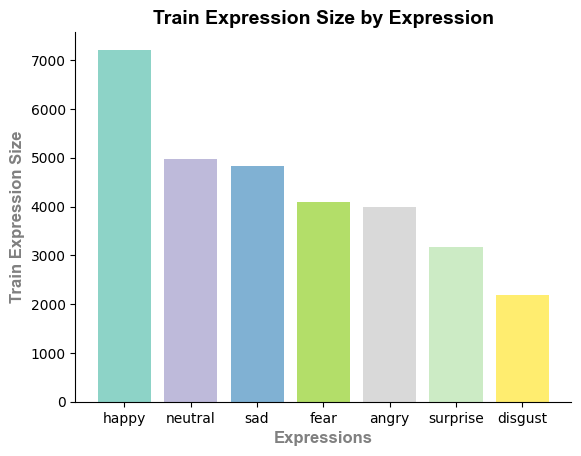

In [44]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "grey", "weight" : "bold", "size" : 12}

sorted_index = np.argsort(train_expression_size)[::-1]

values = np.array(train_expression_size)[sorted_index]
label = np.array(expressions_list)[sorted_index]

colors = plt.cm.Set3(np.linspace(0, 1, len(values)))

plt.bar(label, values, color=colors)

plt.xlabel("Expressions", fontdict=axes_font)
plt.ylabel("Train Expression Size", fontdict=axes_font)
plt.title("Train Expression Size by Expression", fontdict=title_font)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

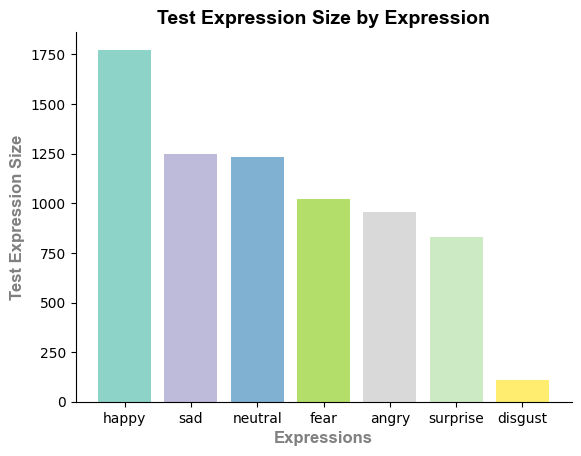

In [45]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "grey", "weight" : "bold", "size" : 12}

sorted_index = np.argsort(test_expression_size)[::-1]

values = np.array(test_expression_size)[sorted_index]
label = np.array(expressions_list)[sorted_index]

colors = plt.cm.Set3(np.linspace(0, 1, len(values)))

plt.bar(label, values, color=colors)

plt.xlabel("Expressions", fontdict=axes_font)
plt.ylabel("Test Expression Size", fontdict=axes_font)
plt.title("Test Expression Size by Expression", fontdict=title_font)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

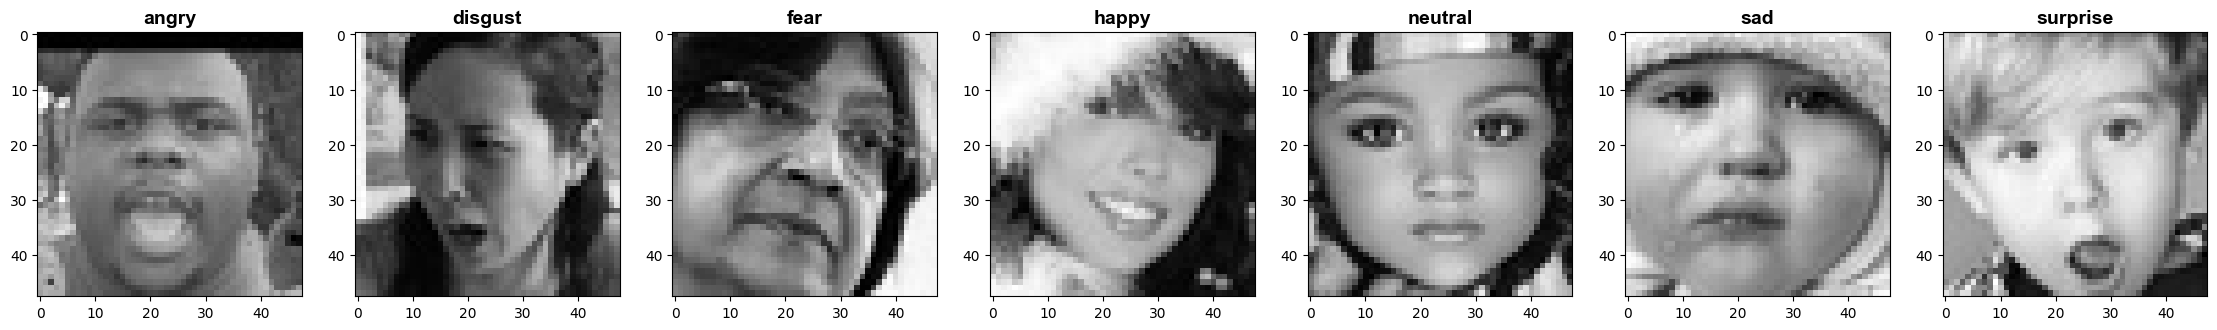

In [46]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}

fig, axes = plt.subplots(1, len(expressions_list), figsize=(len(expressions_list) * 4, 4))

i = 0

while i < len(expressions_list):
    
    expression = expressions_list[i]

    expression_directory = os.path.join(train_directory, expression)
    images_list = os.listdir(expression_directory)
    
    image_directory = os.path.join(expression_directory, random.choice(images_list))
    
    image = cv2.imread(image_directory, cv2.IMREAD_GRAYSCALE)
        
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(expression, fontdict=title_font)
    
    i += 1

plt.show()

In [47]:
data = tf.keras.preprocessing.image_dataset_from_directory(train_directory,
                                                           image_size=(48, 48),
                                                           batch_size=64,
                                                           color_mode="grayscale")
expressions_list = data.class_names
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 30453 files belonging to 7 classes.


In [48]:
data = data.map(lambda x, y: (x/255., y))
batch = data.as_numpy_iterator().next()

print(f"Data Minimum: {batch[0].min()}")
print(f"Data Maximum: {batch[0].max()}")

Data Minimum: 0.0
Data Maximum: 1.0


In [49]:
train_size = int(len(data)*0.875)
validation_size = int(len(data)*0.125)

print(f"The train dataset size will be {train_size}.")
print(f"The validation dataset size will be {validation_size}.")

The train dataset size will be 416.
The validation dataset size will be 59.


In [50]:
train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)

#### Modeling

In [51]:
def get_compiled_model(input_shape, optimizer, loss, metrics):
    model = Sequential()

    # Convolutional and pooling layers
    model.add(Conv2D(32, (3, 3), strides=1, activation="relu",
                     padding="same", input_shape=(48, 48, 1)))
    model.add(Conv2D(64, (3, 3), strides=1, activation="relu",
                     padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Convolutional and pooling layers
    
    model.add(Conv2D(128, (3, 3), strides=1, activation="relu",
                     padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Conv2D(256, (3, 3), strides=1, activation="relu",
                     padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten and dense layer
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Flatten and dense layer
    model.add(Dense(512, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Final layer
    model.add(Dense(7, activation="softmax"))
    
    # Compiler
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [52]:
def train_model(model, train_data, epochs, validation_data, callbacks):
    history = model.fit(train_data,
                        epochs=epochs,
                        validation_data=validation_data,
                        callbacks=callbacks,
                        verbose=1)
    
    return history

In [53]:
class TrainingCallbacks(Callback):
    
    def __init__(self):
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        print("Starting training ...")

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        print(f"Epoch {epoch + 1} completed in {elapsed_time:.2f} seconds")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        print(f"Training finished in {total_time:.2f} seconds")
        
logs_cb = callbacks.TensorBoard(log_dir="logs")

checkpoint = callbacks.ModelCheckpoint(filepath=os.path.join("checkpoints", "model.h5"),
                                       save_best_only=True,
                                       monitor="val_accuracy")
        
callbacks_list = [TrainingCallbacks(), logs_cb, checkpoint]

In [54]:
model = get_compiled_model((48, 48, 1),
                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                           loss="sparse_categorical_crossentropy",
                           metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_89 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_90 (Conv2D)          (None, 24, 24, 128)      

In [55]:
history = train_model(model,
                      train_data=train,
                      epochs=60,
                      validation_data=validation,
                      callbacks=callbacks_list)

Starting training ...
Epoch 1/60


416/416 [==============================] - 19s 42ms/step - loss: 4.5600 - accuracy: 0.2690 - val_loss: 8.1993 - val_accuracy: 0.1801
Epoch 2/60
416/416 [==============================] - 18s 42ms/step - loss: 3.8731 - accuracy: 0.3621 - val_loss: 3.8438 - val_accuracy: 0.3692
Epoch 3/60
416/416 [==============================] - 18s 42ms/step - loss: 3.3775 - accuracy: 0.4194 - val_loss: 3.1379 - val_accuracy: 0.4441
Epoch 4/60
416/416 [==============================] - 18s 42ms/step - loss: 2.9454 - accuracy: 0.4780 - val_loss: 2.7872 - val_accuracy: 0.4947
Epoch 5/60
416/416 [==============================] - 18s 42ms/step - loss: 2.5843 - accuracy: 0.5270 - val_loss: 2.4739 - val_accuracy: 0.5281
Epoch 6/60
416/416 [==============================] - 18s 42ms/step - loss: 2.2830 - accuracy: 0.5707 - val_loss: 2.3450 - val_accuracy: 0.5395
Epoch 7/60
416/416 [==============================] - 18s 42ms/step - loss: 2.0379 - accuracy: 0.5978 - val_loss: 2.0423 - val_accuracy: 0.5763
Epo

In [56]:
history = history.history
history_df = pd.DataFrame(history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,4.559984,0.269043,8.199279,0.180085
1,3.873102,0.362117,3.843799,0.369174
2,3.377537,0.419358,3.137914,0.444121
3,2.945416,0.478027,2.787186,0.494703
4,2.584334,0.527006,2.473855,0.528072
5,2.282966,0.570688,2.344956,0.539460
6,2.037863,0.597807,2.042289,0.576271
7,1.811841,0.637808,1.922117,0.590572
8,1.609874,0.673340,1.924624,0.570710
9,1.432678,0.707632,1.755100,0.606462


#### Plot Model's Evaluation

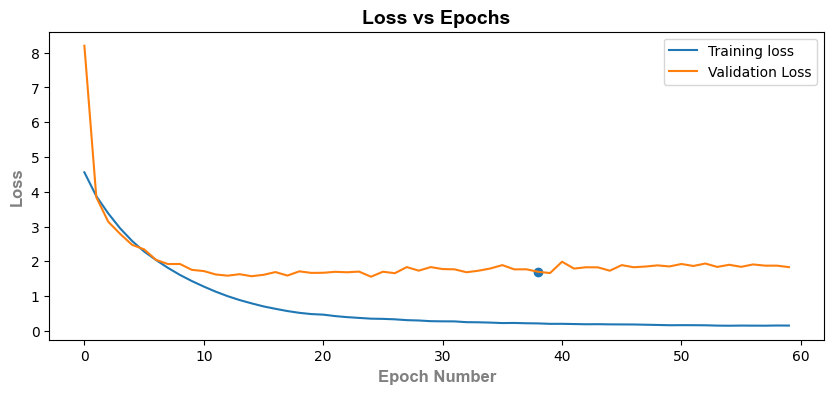

In [57]:
fig = plt.figure(figsize=(10, 4))

plt.plot(history["loss"], label="Training loss")
plt.plot(history["val_loss"], label="Validation Loss")

plt.legend(loc="upper right")

plt.title("Loss vs Epochs", fontdict = title_font)
plt.xlabel("Epoch Number", fontdict = axes_font)
plt.ylabel("Loss", fontdict = axes_font)

max_val_acc_row_index = history_df[history_df["val_accuracy"] == max(history_df["val_accuracy"])].index[-1]

plt.scatter(max_val_acc_row_index,
            history_df.loc[max_val_acc_row_index, "val_loss"])

plt.show()

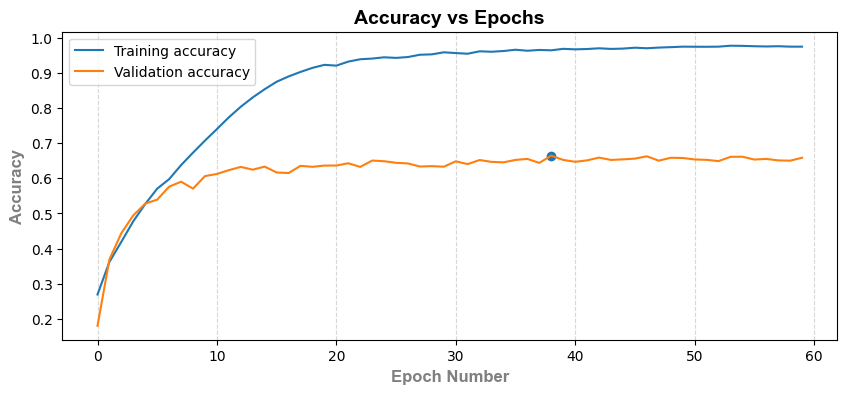

In [58]:
fig = plt.figure(figsize=(10, 4))

plt.plot(history["accuracy"], label="Training accuracy")
plt.plot(history["val_accuracy"], label="Validation accuracy")

plt.legend(loc="upper left")

plt.title("Accuracy vs Epochs", fontdict = title_font)
plt.xlabel("Epoch Number", fontdict = axes_font)
plt.ylabel("Accuracy", fontdict = axes_font)

plt.grid(True, axis="x", alpha=0.5, linestyle="--")

plt.scatter(max_val_acc_row_index,
            history_df.loc[max_val_acc_row_index, "val_accuracy"])

plt.show()

#### Test Evaluation

In [59]:
accuracy = Accuracy()
categorical_accuracy = CategoricalAccuracy()
test_directory = os.path.join(r'C:\Users\ADMIN\Downloads\multi_face_emo_reg','test')
test = tf.keras.preprocessing.image_dataset_from_directory(test_directory,
                                                           image_size=(48, 48),
                                                           batch_size=64,
                                                           color_mode="grayscale")
num_classes = 7
confusion_matrix = np.zeros((num_classes, num_classes))

for batch in test.as_numpy_iterator():

    test_data, test_target = batch
    test_target = to_categorical(test_target, num_classes=num_classes)

    test_target_pred = model.predict(test_data, verbose=0)

    categorical_accuracy.update_state(test_target, test_target_pred)
    accuracy.update_state(test_target, test_target_pred)

    test_target_pred_labels = np.argmax(test_target_pred, axis=1)

    batch_confusion_matrix = sk_confusion_matrix(np.argmax(test_target, axis=1), test_target_pred_labels, labels=range(num_classes))
    confusion_matrix += batch_confusion_matrix

print("Testing Results")
print("-"*30)

print(f"Accuracy               {(accuracy.result()*100):.4f}")
print(f"Categorical Accuracy   {(categorical_accuracy.result()*100):.4f}")

Found 7178 files belonging to 7 classes.
Testing Results
------------------------------
Accuracy               76.6111
Categorical Accuracy   31.3179


#### Confusion Matrix

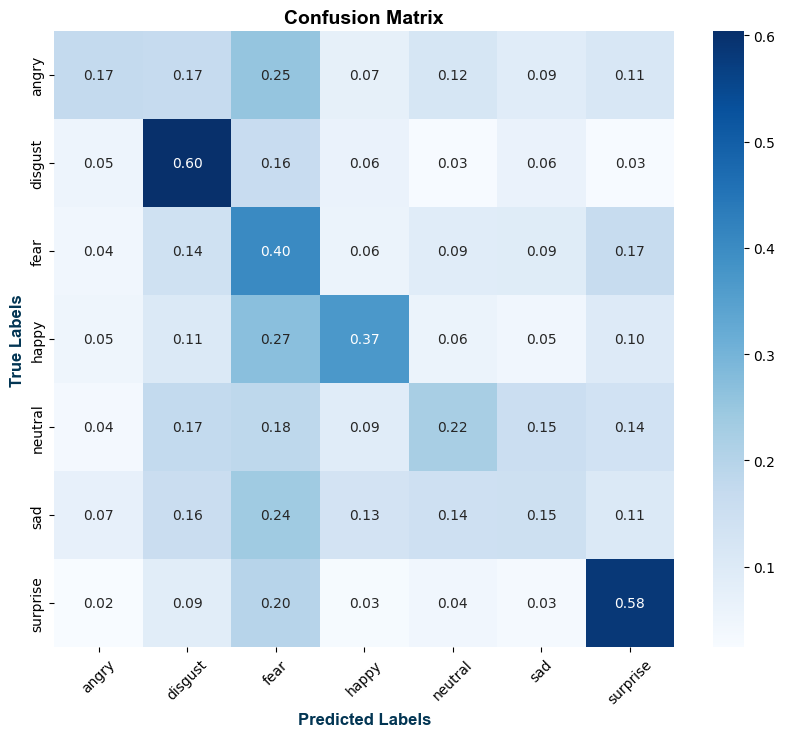

In [60]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "#023553", "weight" : "bold", "size" : 12}

normalized_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(normalized_confusion_matrix, annot=True, fmt=".2f", cmap="Blues")

ax.set_xlabel("Predicted Labels", fontdict=axes_font)
ax.set_ylabel("True Labels", fontdict=axes_font)
ax.set_title("Confusion Matrix", fontdict=title_font)

ax.xaxis.set_ticklabels(expressions_list)
ax.yaxis.set_ticklabels(expressions_list)

plt.xticks(rotation=45)

plt.show()

#### Test Model

1/1 [==============================] - 0s 140ms/step


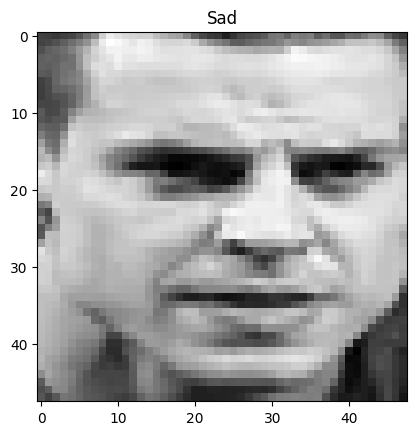

1/1 [==============================] - 0s 28ms/step


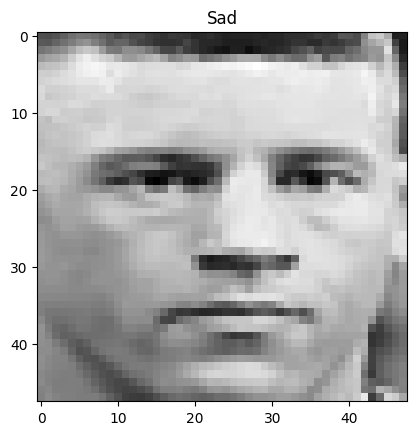

1/1 [==============================] - 0s 28ms/step


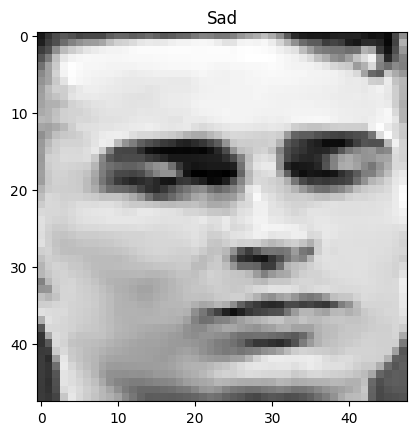

1/1 [==============================] - 0s 28ms/step


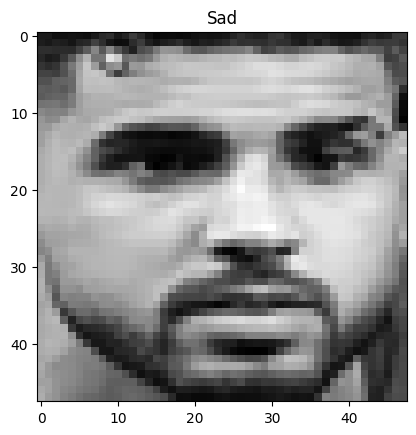

1/1 [==============================] - 0s 28ms/step


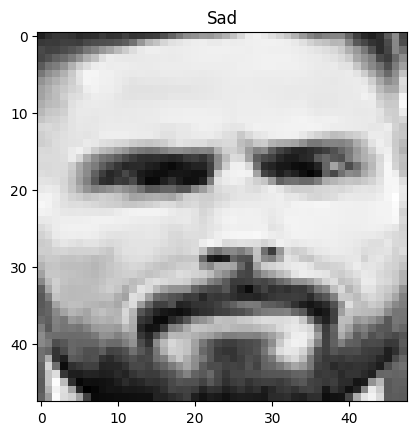

1/1 [==============================] - 0s 27ms/step


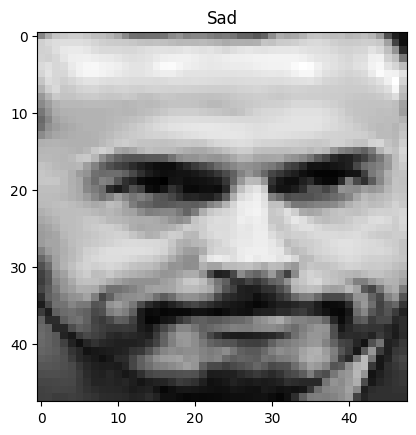

1/1 [==============================] - 0s 27ms/step


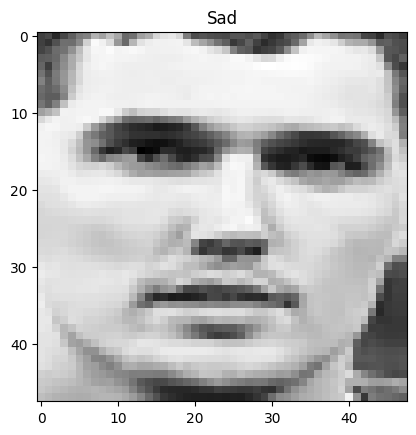

1/1 [==============================] - 0s 27ms/step


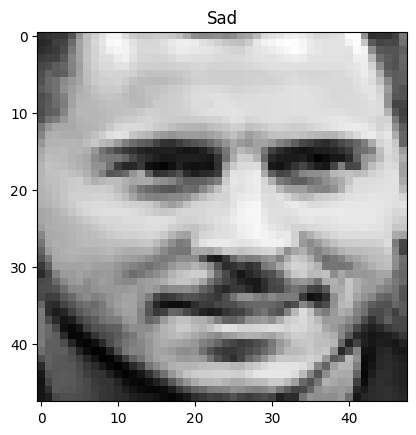

1/1 [==============================] - 0s 29ms/step


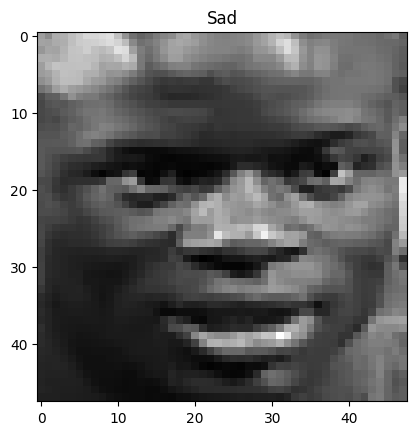

1/1 [==============================] - 0s 34ms/step


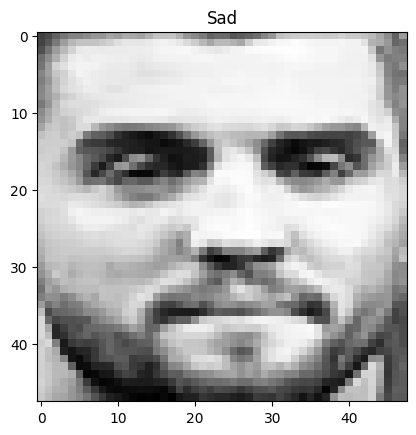

1/1 [==============================] - 0s 31ms/step


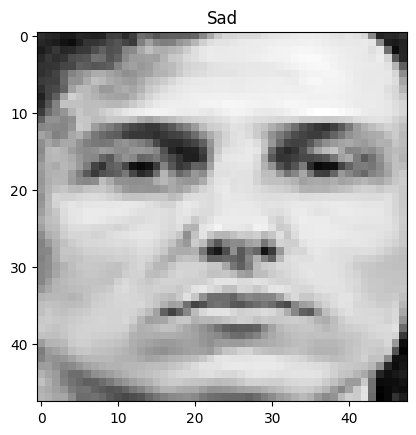

In [61]:
list_image = extract_face_from_image('chelsea.jpg')
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}
#Show all cropped images
for i in range(len(list_image)):
    image = np.expand_dims(image,axis = 0) #makes image shape (1,48,48)
    image = image.reshape(1,48,48,1)
    result = model.predict(image)
    result = list(result[0])
    img_index = result.index(max(result))
    plt.imshow(list_image[i])
    plt.title(label_dict[img_index])
    plt.gray()
    plt.show()